In [39]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when
from pyspark.ml.feature import VectorAssembler, StringIndexer, OneHotEncoder
from pyspark.ml.classification import RandomForestClassifier, GBTClassifier
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from pyspark.sql import functions as F
from pyspark.sql.types import DoubleType

In [40]:
# Initialize Spark session
spark = SparkSession.builder \
    .appName("Random Forest Example") \
    .getOrCreate()

In [ ]:
# Load the data
data = spark.read.csv('../data/train.csv', header=True, inferSchema=True)

In [42]:
# Data exploration
data.show(10)
data.printSchema()
data.describe().show()

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| NULL|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| NULL|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| NULL|       S|
|          6|       0|     3|    Moran, Mr. James|  male|NULL|    0|    0|      

In [43]:
# Visualizations (using Pandas for simplicity)
data_copy = data.toPandas()
fig = plt.figure()

<Figure size 640x480 with 0 Axes>

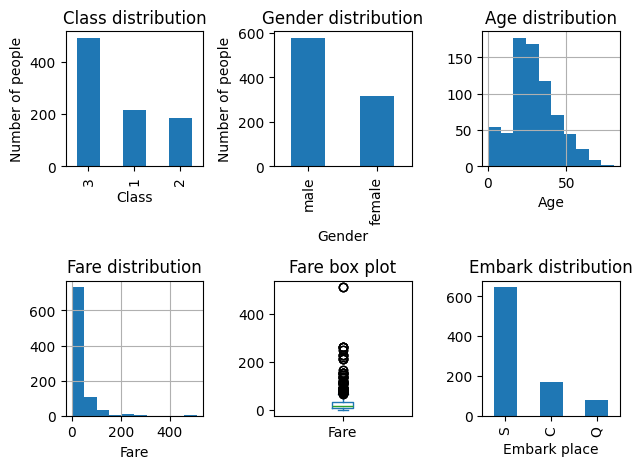

In [44]:
# Pclass
plt.subplot(2, 3, 1)
data_copy['Pclass'].value_counts().plot(kind='bar')
plt.ylabel("Number of people")
plt.xlabel('Class')
plt.title('Class distribution')

# Sex
plt.subplot(2, 3, 2)
data_copy['Sex'].value_counts().plot(kind='bar')
plt.ylabel("Number of people")
plt.xlabel('Gender')
plt.title('Gender distribution')

# Age
plt.subplot(2, 3, 3)
data_copy['Age'].hist()
plt.xlabel('Age')
plt.title('Age distribution')

# Fare
plt.subplot(2, 3, 4)
data_copy['Fare'].hist()
plt.xlabel('Fare')
plt.title('Fare distribution')

# Box plot for Fare
plt.subplot(2, 3, 5)
data_copy['Fare'].plot(kind='box')
plt.title('Fare box plot')

# Embarked
plt.subplot(2, 3, 6)
data_copy['Embarked'].value_counts().plot(kind='bar')
plt.xlabel('Embark place')
plt.title('Embark distribution')

plt.tight_layout()
plt.show()

In [45]:
def preprocessing(data, type):
    # Drop irrelevant features
    data = data.drop(*["Name", "Ticket", "Cabin"])

    # Drop rows with nulls in 'Embarked'
    data = data.na.drop(subset=['Embarked'])

    # Fill NaN values with mean for 'Age' and 'Fare'
    mean_age = data.select('Age').na.drop().agg({'Age': 'mean'}).first()[0]
    mean_fare = data.select('Fare').na.drop().agg({'Fare': 'mean'}).first()[0]
    data = data.na.fill({'Age': mean_age, 'Fare': mean_fare})

    # Create categorical features
    data = data.withColumn("AgeCategory", when(col("Age") < 16, "Very Low")
                           .when((col("Age") >= 16) & (col("Age") < 32), "Low")
                           .when((col("Age") >= 32) & (col("Age") < 48), "Average")
                           .when((col("Age") >= 48) & (col("Age") < 64), "Above Average")
                           .otherwise("High"))

    data = data.withColumn("FareCategory", when(col("Fare") < 10, "Very Low")
                           .when((col("Fare") >= 10) & (col("Fare") < 20), "Low")
                           .when((col("Fare") >= 20) & (col("Fare") < 30), "Average")
                           .when((col("Fare") >= 30) & (col("Fare") < 50), "Above Average")
                           .otherwise("High"))

    # Create Family feature
    data = data.withColumn("Family", col("SibSp") + col("Parch"))

    # Binning Family
    data = data.withColumn("FamilyCategory", when(col("Family") == 0, "Very Low")
                           .when((col("Family") >= 1) & (col("Family") <= 2), "Low")
                           .when((col("Family") >= 3) & (col("Family") <= 4), "Average")
                           .when((col("Family") >= 5) & (col("Family") <= 6), "Above Average")
                           .otherwise("High"))

    # Drop original columns
    data = data.drop("SibSp", "Parch", "Family")

    # StringIndexer for categorical features
    indexers = [
        StringIndexer(inputCol="Pclass", outputCol="PclassIndex"),
        StringIndexer(inputCol="Sex", outputCol="SexIndex"),
        StringIndexer(inputCol="Embarked", outputCol="EmbarkedIndex"),
        StringIndexer(inputCol="AgeCategory", outputCol="AgeCategoryIndex"),
        StringIndexer(inputCol="FareCategory", outputCol="FareCategoryIndex"),
        StringIndexer(inputCol="FamilyCategory", outputCol="FamilyCategoryIndex")
    ]

    # One-hot encoding
    encoders = [
        OneHotEncoder(inputCols=["PclassIndex", "SexIndex", "EmbarkedIndex", 
                                  "AgeCategoryIndex", "FareCategoryIndex", 
                                  "FamilyCategoryIndex"],
                      outputCols=["PclassVec", "SexVec", "EmbarkedVec", 
                                  "AgeCategoryVec", "FareCategoryVec", 
                                  "FamilyCategoryVec"])
    ]

    # Assemble features
    assembler = VectorAssembler(inputCols=["PclassVec", "SexVec", "EmbarkedVec", 
                                           "AgeCategoryVec", "FareCategoryVec", 
                                           "FamilyCategoryVec"], 
                                outputCol="features")

    # Create and fit the pipeline
    pipeline = Pipeline(stages=indexers + encoders + [assembler])
    model = pipeline.fit(data)
    data = model.transform(data)
    # Keep 'PassengerId' in the final DataFrame
    if(type ==0):
        data = data.select("PassengerId", "features", "Survived")
    elif(type == 1):
        data = data.select("PassengerId", "features")
    return data

In [46]:
data_processed = preprocessing(data, 0)

# Prepare features and label
final_data = data_processed.select("PassengerId", "features", "Survived")

# Split the data into training and test sets
train_data, test_data = final_data.randomSplit([0.8, 0.2], seed=42)

In [47]:
train_data.show()

+-----------+--------------------+--------+
|PassengerId|            features|Survived|
+-----------+--------------------+--------+
|          1|(17,[0,2,3,5,9,14...|       0|
|          2|(17,[1,4,6,11,14]...|       1|
|          4|(17,[1,3,6,11,14]...|       1|
|          5|(17,[0,2,3,6,9,13...|       0|
|          6|(17,[0,2,5,9,13],...|       0|
|          8|(17,[0,2,3,7,12,1...|       0|
|         10|(17,[4,7,14],[1.0...|       1|
|         11|(17,[0,3,7,10,14]...|       1|
|         12|(17,[1,3,8,12,13]...|       1|
|         13|(17,[0,2,3,5,9,13...|       0|
|         15|(17,[0,3,7,9,13],...|       0|
|         16|(17,[3,8,10,13],[...|       1|
|         17|(17,[0,2,7,12,16]...|       0|
|         18|(17,[2,3,5,10,13]...|       1|
|         19|(17,[0,3,5,10,14]...|       0|
|         21|(17,[2,3,6,12,13]...|       0|
|         22|(17,[2,3,6,10,13]...|       1|
|         23|(17,[0,7,9,13],[1...|       1|
|         25|(17,[0,3,7,12,15]...|       0|
|         26|(17,[0,3,6,16],[1..

In [48]:
# Initialize and train the Random Forest classifier
rf_classifier = RandomForestClassifier(labelCol="Survived", featuresCol="features", seed=42)
model = rf_classifier.fit(train_data)

# Make predictions
predictions = model.transform(test_data)

# Evaluate the model
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Test Accuracy:", accuracy)

# Hyperparameter tuning using CrossValidator

paramGrid = ParamGridBuilder() \
    .addGrid(rf_classifier.numTrees, [50, 100, 200]) \
    .addGrid(rf_classifier.maxDepth, [10, 20, 30]) \
    .build()

crossval = CrossValidator(estimator=rf_classifier,
                          estimatorParamMaps=paramGrid,
                          evaluator=evaluator,
                          numFolds=5)

cvModel = crossval.fit(train_data)

# Best model
best_rf_classifier = cvModel.bestModel

# Print the hyperparameters of the best model
print("Best Model Hyperparameters:")
print("numTrees:", best_rf_classifier.getNumTrees)
print("maxDepth:", best_rf_classifier.getMaxDepth)
print("minInstancesPerNode:", best_rf_classifier.getMinInstancesPerNode)
print("minInfoGain:", best_rf_classifier.getMinInfoGain)
print("maxBins:", best_rf_classifier.getMaxBins)
print("impurity:", best_rf_classifier.getImpurity)
print("subsamplingRate:", best_rf_classifier.getSubsamplingRate)
print("seed:", best_rf_classifier.getSeed)

# Make predictions with the best estimator
best_predictions = best_rf_classifier.transform(test_data)

# Evaluate the best model
best_accuracy = evaluator.evaluate(best_predictions)
print("Best Model Test Accuracy:", best_accuracy)

if(accuracy>best_accuracy):
    print("not improving")
    best_rf_classifier = model
    best_predictions = predictions
    best_accuracy = accuracy

Test Accuracy: 0.8137931034482758
Best Model Hyperparameters:
numTrees: 200
maxDepth: <bound method _DecisionTreeParams.getMaxDepth of RandomForestClassificationModel: uid=RandomForestClassifier_d22a06cd933f, numTrees=200, numClasses=2, numFeatures=17>
minInstancesPerNode: <bound method _DecisionTreeParams.getMinInstancesPerNode of RandomForestClassificationModel: uid=RandomForestClassifier_d22a06cd933f, numTrees=200, numClasses=2, numFeatures=17>
minInfoGain: <bound method _DecisionTreeParams.getMinInfoGain of RandomForestClassificationModel: uid=RandomForestClassifier_d22a06cd933f, numTrees=200, numClasses=2, numFeatures=17>
maxBins: <bound method _DecisionTreeParams.getMaxBins of RandomForestClassificationModel: uid=RandomForestClassifier_d22a06cd933f, numTrees=200, numClasses=2, numFeatures=17>
impurity: <bound method _TreeClassifierParams.getImpurity of RandomForestClassificationModel: uid=RandomForestClassifier_d22a06cd933f, numTrees=200, numClasses=2, numFeatures=17>
subsampling

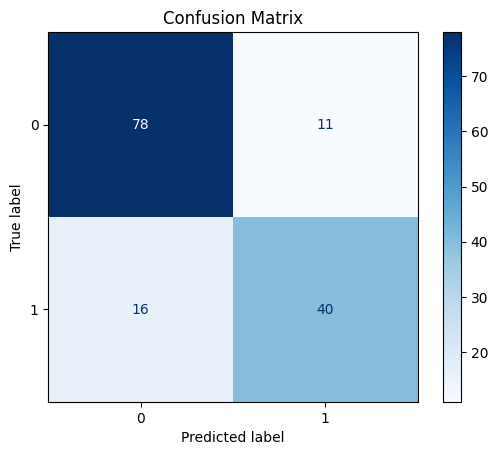

In [49]:
#confusion matrix
# Get predictions
y_true = best_predictions.select("Survived").toPandas()
y_pred = best_predictions.select("prediction").toPandas()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

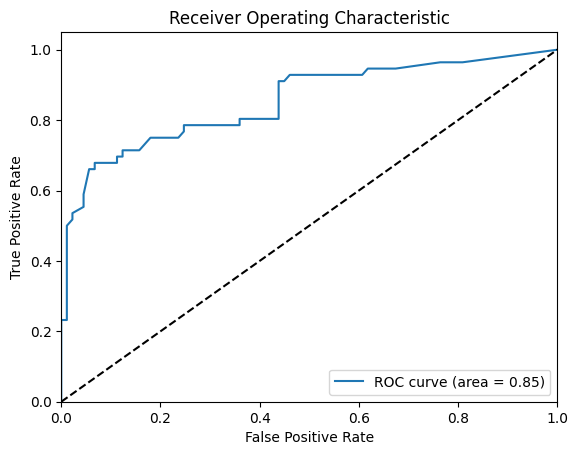

In [50]:
#ROC curve
# Get probabilities
probabilities = best_predictions.select("probability").toPandas()
y_probs = probabilities['probability'].apply(lambda x: x[1])  # Get probabilities for the positive class

# Get true labels
y_true = best_predictions.select("Survived").toPandas()

# Compute ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_true, y_probs)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()

In [51]:
#Esemble learning with Stacking
# Initialize classifiers
rf_classifier = RandomForestClassifier(labelCol="Survived", featuresCol="features", seed=42)
gbt_classifier = GBTClassifier(labelCol="Survived", featuresCol="features", maxIter=100)

# Fit both models
rf_model = rf_classifier.fit(train_data)
gbt_model = gbt_classifier.fit(train_data)

# Make predictions
rf_predictions = rf_model.transform(test_data)
gbt_predictions = gbt_model.transform(test_data)

# Select relevant columns and join predictions
rf_results = rf_predictions.select("PassengerId", "prediction", "Survived").withColumnRenamed("prediction", "rf_prediction")
gbt_results = gbt_predictions.select("PassengerId", "prediction").withColumnRenamed("prediction", "gbt_prediction")

# Join the predictions
combined_predictions = rf_results.join(gbt_results, on="PassengerId")

# Majority voting for final prediction
final_predictions = combined_predictions.withColumn(
    "final_prediction",
    F.when((combined_predictions.rf_prediction == 1) | (combined_predictions.gbt_prediction == 1), 1)
     .otherwise(0).cast(DoubleType())  # Cast to DoubleType
)

# Evaluate the final model
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="final_prediction", metricName="accuracy")
accuracy = evaluator.evaluate(final_predictions)
print("Stacked Model Test Accuracy:", accuracy)

Stacked Model Test Accuracy: 0.7724137931034483


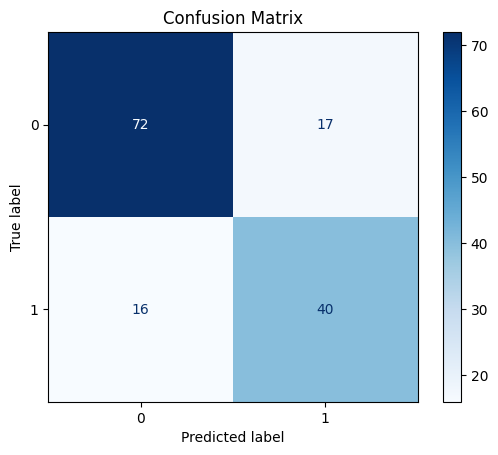

In [52]:
#confusion matrix
# Get predictions
y_true = final_predictions.select("Survived").toPandas()
y_pred = final_predictions.select("final_prediction").toPandas()

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# For deployment
deploy_data = spark.read.csv('../data/test.csv', header=True, inferSchema=True)

# Preprocess the deployment data
deploy_data_processed = preprocessing(deploy_data, 1)

# Prepare features for deployment
deploy_final_data = deploy_data_processed.select("features", "PassengerId")  # Retain PassengerId

# Make predictions on deployment data using the best model
deploy_results = best_rf_classifier.transform(deploy_final_data)

# Combine PassengerId with predictions
result_df = deploy_results.select("PassengerId", "prediction")  # Select both PassengerId and prediction
result_df = result_df.withColumnRenamed("prediction", "Survived")  # Rename the prediction column to Survived

# Print the schema and check for null values
result_df.printSchema()
null_count = result_df.filter(result_df["Survived"].isNull()).count()
print(f"Null values in Survived: {null_count}")

# Convert to Pandas DataFrame
pandas_df = result_df.toPandas()
# Save as CSV using Pandas
pandas_df.to_csv('result/rf_result.csv', index=False)
# Stop the Spark session
spark.stop()


root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: double (nullable = false)

Null values in Survived: 0
